In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
import glob
import os

In [22]:
bnei_brak = pd.read_csv("data/bnei_brak_summer_2010.csv")

In [178]:
def fix_24_hour_format(date_str):
    if len(date_str)<=5:
        dt = pd.to_datetime(int(date_str), origin="1899-12-30", unit="D")
        formatted_time = dt.strftime("%H:%M %d/%m/%Y")
        return formatted_time
        
    if '24:00' in date_str:
        # Split time and date
        time_part, date_part = date_str.split(' ')
        # Replace "24:00" with "00:00" and shift date to next day
        corrected_date = (pd.to_datetime(date_part, format='%d/%m/%Y') + pd.Timedelta(days=1)).strftime('%d/%m/%Y')
        return f"00:00 {corrected_date}"
    return date_str

In [133]:
def safe_function(date_str):
    try:
        return fix_24_hour_format(date_str)
    except Exception as e:
        print(f"Error with input: {date_str} - {e}")  # Print or log the error
        return None  # Return None or some other default value

In [23]:
bnei_brak['corrected_datetime'] = bnei_brak['date_time'].apply(fix_24_hour_format)

In [24]:
bnei_brak['datetime'] = pd.to_datetime(bnei_brak['corrected_datetime'], format='%H:%M %d/%m/%Y')

In [25]:
bnei_brak.drop(["date_time", "corrected_datetime"], axis=1, inplace=True)

In [33]:
bnei_brak = bnei_brak.rename(columns = {'Bnei_brak_highway4':'co'})

In [27]:
bnei_brak["co"] = bnei_brak["co"].apply(pd.to_numeric, errors='coerce')

In [29]:
bnei_brak["co"] = bnei_brak["co"].map(lambda x: np.nan if x<0 else x) 

In [34]:
missing_by_date = (
    bnei_brak.groupby([bnei_brak["datetime"].dt.year.rename("Year"), 
                       bnei_brak["datetime"].dt.month.rename("Month"), 
                       bnei_brak["datetime"].dt.day.rename("Day")])["co"]
    .apply(lambda x: x.isna().sum()).reset_index(name = "NaN Count")
)

In [39]:
    bnei_brak.groupby([bnei_brak["datetime"].dt.year.rename("Year"), 
                       bnei_brak["datetime"].dt.month.rename("Month")])["co"].mean().reset_index()

,Year,Month,co
0,2010,7,1.064489
1,2010,8,1.185289
2,2010,9,1.600000


# Compare half-hour aggregation to daily

In [179]:
# read files
files = glob.glob("data/Bnei_brak_check/*.csv")
df_list = [pd.read_csv(file) for file in files]
bnei_brak = pd.concat(df_list, ignore_index = True)

In [180]:
# correct datetime
bnei_brak['corrected_datetime'] = bnei_brak['date_time'].apply(fix_24_hour_format)
bnei_brak['datetime'] = pd.to_datetime(bnei_brak['corrected_datetime'], format='%H:%M %d/%m/%Y')
bnei_brak.drop(["date_time", "corrected_datetime"], axis=1, inplace=True)
bnei_brak = bnei_brak.rename(columns = {'Bnei_brak_highway4':'co'})

In [181]:
# define na and correct negative (out of calibration) values
bnei_brak["co"] = bnei_brak["co"].apply(pd.to_numeric, errors='coerce')
bnei_brak["co"] = bnei_brak["co"].map(lambda x: 0 if x<0 else x) 

In [183]:
daily = bnei_brak.groupby([bnei_brak["datetime"].dt.year.rename("Year"), 
                   bnei_brak["datetime"].dt.month.rename("Month"), 
                   bnei_brak["datetime"].dt.day.rename("Day")])["co"].mean().reset_index()
daily["date_time"] = pd.to_datetime(daily[["Year","Month", "Day"]])
daily.drop(["Year","Month", "Day"], axis=1, inplace=True)

In [184]:
site_daily_bnei_brak = pd.read_csv('data/air_data_clean.csv', usecols=["date_time", "Bnei_brak_highway4"])

In [63]:
def preprocessing_air_data(df):
    df['date_time']=pd.to_datetime(df['date_time'], origin='1899-12-30', unit='D')
    df['date_time'] = pd.to_datetime(df['date_time'], format='%d/%m/%Y')
    
    # # Replace '<Samp' values with 0
    # df = df.replace('<Samp', 0)
    
    # Convert all non-numeric values (except dates) to NaN
    numeric_columns = df.columns[1:]  # All columns except the date column
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Convert negative values to 0
    df[numeric_columns] = df[numeric_columns].clip(lower=0)

    # convert negative values to NaN
    # df[numeric_columns] = df[numeric_columns].map(lambda x: np.nan if x < 0 else x)

    return df

In [185]:
site_daily_bnei_brak = preprocessing_air_data(site_daily_bnei_brak)

In [186]:
site_daily_bnei_brak['date_time']  = site_daily_bnei_brak['date_time'] - pd.Timedelta(days=1) 

In [187]:
site_daily_bnei_brak = site_daily_bnei_brak.rename(columns={"Bnei_brak_highway4": "co"})

In [188]:
daily_bnei_brak = site_daily_bnei_brak.merge(daily, how='inner', left_on='date_time', right_on='date_time', suffixes=('_site', '_agg'))

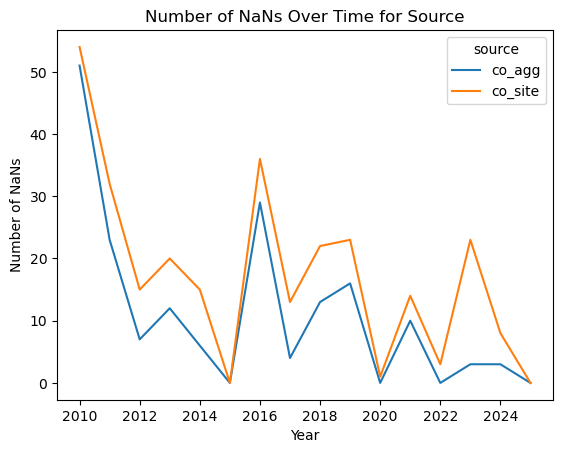

In [190]:
bnei_brak_long = daily_bnei_brak.melt(id_vars = ['date_time'], var_name = 'date_source', value_name='co')

nan_by_year = bnei_brak_long.groupby([bnei_brak_long['date_time'].dt.year, 
                      'date_source'])['co'].apply(lambda x: x.isna().sum()).reset_index(name = "NaN Count")
					  
sns.lineplot(data = nan_by_year, x='date_time', y='NaN Count', hue='date_source')
plt.xlabel("Year")
plt.ylabel("Number of NaNs")
plt.title("Number of NaNs Over Time for Source")
plt.legend(title="source")
plt.show()

In [191]:
nan_by_year.groupby('date_source')['NaN Count'].sum().reset_index()

,date_source,NaN Count
0,co_agg,177
1,co_site,279


In [192]:
monthly_bnei_brak = daily_bnei_brak.groupby([
        daily_bnei_brak['date_time'].dt.year.rename('year'),
        daily_bnei_brak['date_time'].dt.month.rename('month'),
    ])[daily_bnei_brak.columns[1:]].mean().reset_index()
monthly_bnei_brak['date'] = pd.to_datetime(monthly_bnei_brak[['year','month']].assign(day=1))
monthly_bnei_brak = monthly_bnei_brak.drop(["year","month"], axis =1)

In [193]:
monthly_bnei_brak_longer = monthly_bnei_brak.melt(id_vars=['date'], var_name='data_source', value_name='co')

In [194]:
def extract_decomposition(group, period_months, value_name='co'):
    group = group.dropna(subset=[value_name])
    decomposition = seasonal_decompose(group[value_name], period=period_months, model='additive', extrapolate_trend='freq')
    group['Observed'] = decomposition.observed
    group['Trend'] = decomposition.trend
    group['Seasonal'] = decomposition.seasonal
    group['Residuals'] = decomposition.resid
    return group

In [195]:
decomposition = (
    monthly_bnei_brak_longer.set_index("data_source")
    .groupby("data_source", group_keys=False, sort=False)
    .apply(extract_decomposition, period_months=12)
    .reset_index()
)

In [201]:
def plot_spectral(df, spectral_component):
    plt.figure(figsize = (12, 6))
    sns.lineplot(data = df, x="date", y=spectral_component, hue = "data_source")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel("Year")
    plt.ylabel(spectral_component)
    plt.title("{} component of spectral decomposition for all monitoring stations".format(spectral_component))
    plt.show()

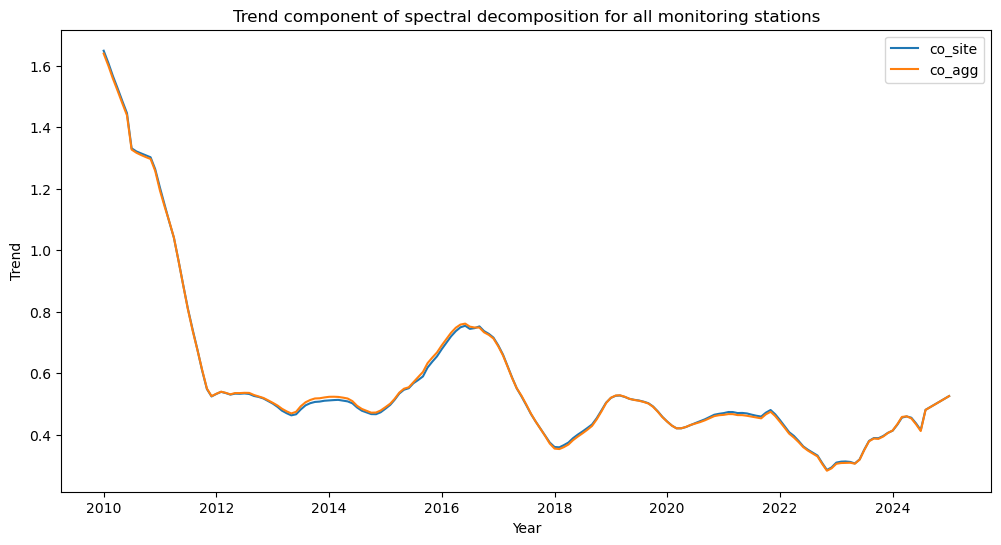

In [202]:
plot_spectral(decomposition, "Trend")

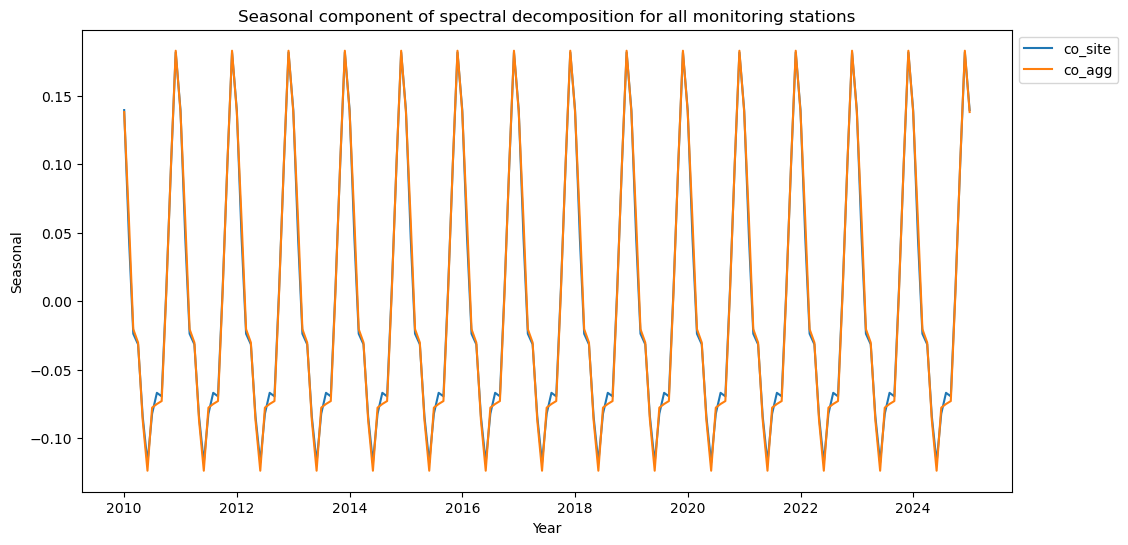

In [203]:
plot_spectral(decomposition, "Seasonal")